```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Inventory Dynamics

```{include} _admonition/gpu.md
```

```{index} single: Markov process, inventory
```

## Overview

This lecture explores the inventory dynamics of a firm using so-called s-S inventory control.

Loosely speaking, this means that the firm 

* waits until inventory falls below some value $s$
* and then restocks with a bulk order of $S$ units (or, in some models, restocks up to level $S$).

We will be interested in the distribution of the associated Markov process,
which can be thought of as cross-sectional distributions of inventory levels
across a large number of firms, all of which 

1. evolve independently and
1. have the same dynamics.

Note that we also studied this model in a [separate
lecture](https://python.quantecon.org/inventory_dynamics.html), using Numba.

Here we study the same problem using JAX.

We will use the following imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, lax
from collections import namedtuple

Here's a description of our GPU:

In [2]:
!nvidia-smi

/opt/conda/envs/quantecon/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Thu Mar 14 01:44:57 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 12.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|


|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   27C    P0    36W / 300W |      0MiB / 16160MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+


## Sample paths

Consider a firm with inventory $X_t$.

The firm waits until $X_t \leq s$ and then restocks up to $S$ units.

It faces stochastic demand $\{ D_t \}$, which we assume is IID across time and
firms.

With notation $a^+ := \max\{a, 0\}$, inventory dynamics can be written
as

$$
X_{t+1} =
    \begin{cases}
      ( S - D_{t+1})^+ & \quad \text{if } X_t \leq s \\
      ( X_t - D_{t+1} )^+ &  \quad \text{if } X_t > s
    \end{cases}
$$

In what follows, we will assume that each $D_t$ is lognormal, so that

$$
    D_t = \exp(\mu + \sigma Z_t)
$$

where $\mu$ and $\sigma$ are parameters and $\{Z_t\}$ is IID
and standard normal.

Here's a `namedtuple` that stores parameters.

In [3]:
Parameters = namedtuple('Parameters', ['s', 'S', 'μ', 'σ'])

# Create a default instance
params = Parameters(s=10, S=100, μ=1.0, σ=0.5)

## Cross-sectional distributions

Now let’s look at the marginal distribution $\psi_T$ of $X_T$ for some fixed $T$.

The probability distribution $\psi_T$ is the time $T$ distribution of firm
inventory levels implied by the model.

We will approximate this distribution by 

1. fixing $n$ to be some large number, indicating the number of firms in the
   simulation,
1. fixing $T$, the time period we are interested in,
1. generating $n$ independent draws from some fixed distribution $\psi_0$ that gives the
   initial cross-section of inventories for the $n$ firms, and
1. shifting this distribution forward in time $T$ periods, updating each firm
    $T$ times via the dynamics described above (independent of other firms).

We will then visualize $\psi_T$ by histogramming the cross-section.

We will use the following code to update the cross-section of firms by one period.

In [4]:
@jax.jit
def update_cross_section(params, X_vec, D):
    """
    Update by one period a cross-section of firms with inventory levels given by
    X_vec, given the vector of demand shocks in D.

       * D[i] is the demand shock for firm i with current inventory X_vec[i]

    """
    # Unpack
    s, S = params.s, params.S
    # Restock if the inventory is below the threshold
    X_new = jnp.where(X_vec <= s, 
                      jnp.maximum(S - D, 0), jnp.maximum(X_vec - D, 0))
    return X_new

### For loop version

Now we provide code to compute the cross-sectional distribution $\psi_T$ given some
initial distribution $\psi_0$ and a positive integer $T$.

In this code we use an ordinary Python `for` loop to step forward through time

While Python loops are slow, this approach is reasonable here because
efficiency of outer loops has far less influence on runtime than efficiency of inner loops.

(Below we will squeeze out more speed by compiling the outer loop as well as the
update rule.)

In the code below, the initial distribution $\psi_0$ takes all firms to have
initial inventory `x_init`.

In [5]:
def compute_cross_section(params, x_init, T, key, num_firms=50_000):
    # Set up initial distribution
    X_vec = jnp.full((num_firms, ), x_init)
    # Loop
    for i in range(T):
        Z = random.normal(key, shape=(num_firms, ))
        D = jnp.exp(params.μ + params.σ * Z)

        X_vec = update_cross_section(params, X_vec, D)
        _, key = random.split(key)

    return X_vec

We'll use the following specification

In [6]:
x_init = 50
T = 500
# Initialize random number generator
key = random.PRNGKey(10)

Let's look at the timing.

In [7]:
%time X_vec = compute_cross_section(params, \
        x_init, T, key).block_until_ready()

CPU times: user 1.31 s, sys: 447 ms, total: 1.75 s
Wall time: 976 ms


In [8]:
%time X_vec = compute_cross_section(params, \
        x_init, T, key).block_until_ready()

CPU times: user 1.06 s, sys: 345 ms, total: 1.4 s
Wall time: 562 ms


Here's a histogram of inventory levels at time $T$.

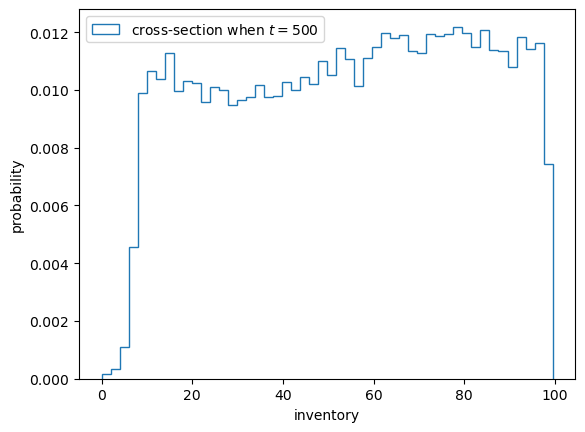

In [9]:
fig, ax = plt.subplots()
ax.hist(X_vec, bins=50, 
        density=True, 
        histtype='step', 
        label=f'cross-section when $t = {T}$')
ax.set_xlabel('inventory')
ax.set_ylabel('probability')
ax.legend()
plt.show()

### Compiling the outer loop

Now let's see if we can gain some speed by compiling the outer loop, which steps
through the time dimension.

We will do this using `jax.jit` and a `fori_loop`, which is a compiler-ready version of a `for` loop provided by JAX.

In [10]:
def compute_cross_section_fori(params, x_init, T, key, num_firms=50_000):

    s, S, μ, σ = params.s, params.S, params.μ, params.σ
    X = jnp.full((num_firms, ), x_init)

    # Define the function for each update
    def fori_update(t, inputs):
        # Unpack
        X, key = inputs
        # Draw shocks using key
        Z = random.normal(key, shape=(num_firms,))
        D = jnp.exp(μ + σ * Z)
        # Update X
        X = jnp.where(X <= s,
                  jnp.maximum(S - D, 0),
                  jnp.maximum(X - D, 0))
        # Refresh the key
        key, subkey = random.split(key)
        return X, subkey

    # Loop t from 0 to T, applying fori_update each time.
    # The initial condition for fori_update is (X, key).
    X, key = lax.fori_loop(0, T, fori_update, (X, key))

    return X

# Compile taking T and num_firms as static (changes trigger recompile)
compute_cross_section_fori = jax.jit(
    compute_cross_section_fori, static_argnums=(2, 4))

Let's see how fast this runs with compile time.

In [11]:
%time X_vec = compute_cross_section_fori(params, \
    x_init, T, key).block_until_ready()

CPU times: user 300 ms, sys: 0 ns, total: 300 ms
Wall time: 209 ms


And let's see how fast it runs without compile time.

In [12]:
%time X_vec = compute_cross_section_fori(params, \
    x_init, T, key).block_until_ready()

CPU times: user 17 ms, sys: 0 ns, total: 17 ms
Wall time: 14.8 ms


Compared to the original version with a pure Python outer loop, we have 
produced a nontrivial speed gain.


This is due to the fact that we have compiled the whole operation.




### Further vectorization

For relatively small problems, we can make this code run even faster by generating
all random variables at once.

This improves efficiency because we are taking more operations out of the loop.

In [13]:
def compute_cross_section_fori(params, x_init, T, key, num_firms=50_000):

    s, S, μ, σ = params.s, params.S, params.μ, params.σ
    X = jnp.full((num_firms, ), x_init)
    Z = random.normal(key, shape=(T, num_firms))
    D = jnp.exp(μ + σ * Z)

    def update_cross_section(i, X):
        X = jnp.where(X <= s,
                  jnp.maximum(S - D[i, :], 0),
                  jnp.maximum(X - D[i, :], 0))
        return X

    X = lax.fori_loop(0, T, update_cross_section, X)

    return X

# Compile taking T and num_firms as static (changes trigger recompile)
compute_cross_section_fori = jax.jit(
    compute_cross_section_fori, static_argnums=(2, 4))

Let's test it with compile time included.

In [14]:
%time X_vec = compute_cross_section_fori(params, \
    x_init, T, key).block_until_ready()

CPU times: user 230 ms, sys: 0 ns, total: 230 ms
Wall time: 212 ms


Let's run again to eliminate compile time.

In [15]:
%time X_vec = compute_cross_section_fori(params, \
    x_init, T, key).block_until_ready()

CPU times: user 5.8 ms, sys: 0 ns, total: 5.8 ms
Wall time: 4.85 ms


On one hand, this version is faster than the previous one, where random variables were
generated inside the loop.

On the other hand, this implementation consumes far more memory, as we need to
store large arrays of random draws.

The high memory consumption becomes problematic for large problems.



## Distribution dynamics

Next let's take a look at how the distribution sequence evolves over time.

We will go back to using ordinary Python `for` loops.

Here is code that repeatedly shifts the cross-section forward while
recording the cross-section at the dates in `sample_dates`.

In [16]:
def shift_forward_and_sample(x_init, params, sample_dates,
                        key, num_firms=50_000, sim_length=750):

    X = res = jnp.full((num_firms, ), x_init)

    # Use for loop to update X and collect samples
    for i in range(sim_length):
        Z = random.normal(key, shape=(num_firms, ))
        D = jnp.exp(params.μ + params.σ * Z)

        X = update_cross_section(params, X, D)
        _, key = random.split(key)

        # draw a sample at the sample dates
        if (i+1 in sample_dates):
          res = jnp.vstack((res, X))

    return res[1:]

Let's test it

In [17]:
x_init = 50
num_firms = 10_000
sample_dates = 10, 50, 250, 500, 750
key = random.PRNGKey(10)


%time X = shift_forward_and_sample(x_init, params, \
                              sample_dates, key).block_until_ready()

CPU times: user 2.17 s, sys: 0 ns, total: 2.17 s
Wall time: 1.04 s


Let's plot the output.

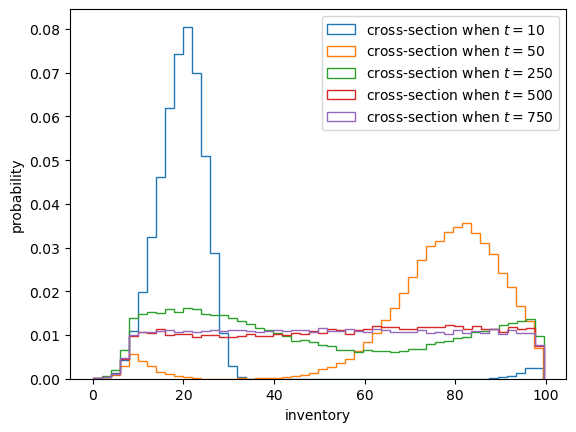

In [18]:
fig, ax = plt.subplots()

for i, date in enumerate(sample_dates):
    ax.hist(X[i, :], bins=50, 
            density=True, 
            histtype='step',
            label=f'cross-section when $t = {date}$')

ax.set_xlabel('inventory')
ax.set_ylabel('probability')
ax.legend()
plt.show()

This model for inventory dynamics is asymptotically stationary, with a unique
stationary distribution.

In particular, the sequence of marginal distributions $\{\psi_t\}$
converges to a unique limiting distribution that does not depend on
initial conditions.

Although we will not prove this here, we can see it in the simulation above.

By $t=500$ or $t=750$ the distributions are barely changing.

If you test a few different initial conditions, you will see that they do not affect long-run outcomes.





## Restock frequency

As an exercise, let's study the probability that firms need to restock over a given time period.

In the exercise, we will

* set the starting stock level to $X_0 = 70$ and
* calculate the proportion of firms that need to order twice or more in the first 50 periods.

This proportion approximates the probability of the event when the sample size
is large.


### For loop version

We start with an easier `for` loop implementation

In [19]:
# Define a jitted function for each update
@jax.jit
def update_stock(n_restock, X, params, D):
    n_restock = jnp.where(X <= params.s,
                          n_restock + 1,
                          n_restock)
    X = jnp.where(X <= params.s,
                  jnp.maximum(params.S - D, 0),
                  jnp.maximum(X - D, 0))
    return n_restock, X, key

def compute_freq(params, key,
                 x_init=70,
                 sim_length=50,
                 num_firms=1_000_000):

    # Prepare initial arrays
    X = jnp.full((num_firms, ), x_init)

    # Stack the restock counter on top of the inventory
    n_restock = jnp.zeros((num_firms, ))

    # Use a for loop to perform the calculations on all states
    for i in range(sim_length):
        Z = random.normal(key, shape=(num_firms, ))
        D = jnp.exp(params.μ + params.σ * Z)
        n_restock, X, key = update_stock(
            n_restock, X, params, D)
        key = random.fold_in(key, i)

    return jnp.mean(n_restock > 1, axis=0)

In [20]:
key = random.PRNGKey(27)
%time freq = compute_freq(params, key).block_until_ready()
print(f"Frequency of at least two stock outs = {freq}")

CPU times: user 644 ms, sys: 0 ns, total: 644 ms
Wall time: 632 ms
Frequency of at least two stock outs = 0.4472379982471466


```{exercise-start}
:label: inventory_dynamics_ex1
```

Write a `fori_loop` version of the last function.  See if you can increase the 
speed while generating a similar answer.

```{exercise-end}
```

```{solution-start} inventory_dynamics_ex1
:class: dropdown
```

Here is a `lax.fori_loop` version that JIT compiles the whole function

In [21]:
@jax.jit
def compute_freq(params, key,
                 x_init=70,
                 sim_length=50,
                 num_firms=1_000_000):

    s, S, μ, σ = params.s, params.S, params.μ, params.σ
    # Prepare initial arrays
    X = jnp.full((num_firms, ), x_init)
    Z = random.normal(key, shape=(sim_length, num_firms))
    D = jnp.exp(μ + σ * Z)

    # Stack the restock counter on top of the inventory
    restock_count = jnp.zeros((num_firms, ))
    Xs = (X, restock_count)

    # Define the function for each update
    def update_cross_section(i, Xs):
        # Separate the inventory and restock counter
        x, restock_count = Xs[0], Xs[1]
        restock_count = jnp.where(x <= s,
                                restock_count + 1,
                                restock_count)
        x = jnp.where(x <= s,
                      jnp.maximum(S - D[i], 0),
                      jnp.maximum(x - D[i], 0))

        Xs = (x, restock_count)
        return Xs

    # Use lax.fori_loop to perform the calculations on all states
    X_final = lax.fori_loop(0, sim_length, update_cross_section, Xs)

    return jnp.mean(X_final[1] > 1)

Note the time the routine takes to run, as well as the output

In [22]:
%time freq = compute_freq(params, key).block_until_ready()
%time freq = compute_freq(params, key).block_until_ready()

print(f"Frequency of at least two stock outs = {freq}")

CPU times: user 335 ms, sys: 0 ns, total: 335 ms
Wall time: 287 ms
CPU times: user 2.47 ms, sys: 0 ns, total: 2.47 ms
Wall time: 4.83 ms
Frequency of at least two stock outs = 0.44674399495124817


```{solution-end}
```